# Heat transport in FOCI-OpenIFS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.signal import welch, coherence, cwt
from scipy import signal
import seaborn as sns
import string
from pathlib import Path
import xgcm
from xorca.lib import load_xorca_dataset

In [2]:
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
sns.set_style("ticks")

In [3]:
from dask.distributed import Client, LocalCluster, wait

In [4]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37423 instead
  expected, actual


In [5]:
client

Client Scheduler: tcp://127.0.0.1:39791 Dashboard: http://127.0.0.1:37423/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


## Read NESH

In [6]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'
    new_maskglo = '/gxfs_work1/geomar/smomw352/new_maskglo.nc'

In [50]:
# NEMO mesh
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_e2t = (ds_mesh['e2t']).sel(t=0)
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_dept = ds_mesh['e3t'].mean('x').sel(t=0).rename({'z':'deptht'})
da_orca05_depv = ds_mesh['e3v'].mean('x').sel(t=0).rename({'z':'depthv'})

In [8]:
# Basin zonal volume
ds_maskglo = xr.open_dataset(new_maskglo).rename({'X':'x', 'Y':'y'})
maskatl = ds_maskglo['tmaskatl']
maskpac = ds_maskglo['tmaskpac']
maskind = ds_maskglo['tmaskind']

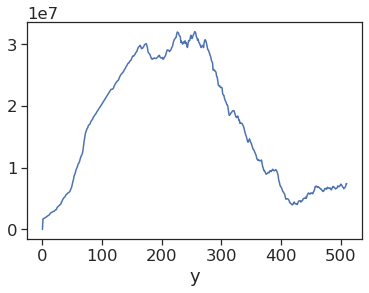

In [9]:
dy_glo = (ds_mesh['e2t'].sel(t=0) * da_orca05_mask).sum('x')
dy_atl = (ds_mesh['e2t'].sel(t=0) * maskatl).sum('x')
dy_glo.plot()

## Read NEMO

In [32]:
exp_list = ['FOCI_GJK001','FOCI_GJK001']
label_list = ['Warm phase','Cold phase']
time_list = [slice('2200-01-01','2400-01-01'), slice('2600-01-01','2800-01-01')]
#time_list = [slice('1850-01-01','1860-01-01'), slice('1850-01-01','1860-01-01')]

In [33]:
# NEMO derived
ds_vt_all = []
ds_vt_eiv_all = []

for exp,time in zip(exp_list,time_list):
    
    #data_path = Path('/%s/%s/outdata/nemo/' % (esmdir,exp))
    
    #v = sorted(data_path.glob('%s_1m_*_grid_V.nc' % (exp,)))
    #t = sorted(data_path.glob('%s_1m_*_grid_T.nc' % (exp,)))
    
    #ds_t = load_xorca_dataset(data_files = v,
    #                          aux_files = [nemo_mesh], use_cftime=True)
    #grid = xgcm.Grid(ds_t, periodic=['y','x'])
    
    vt = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*vT_zm.nc' % (esmdir,exp,exp)
    print(vt)
    ds_vt = xr.open_mfdataset(vt,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_vt_all.append(ds_vt)
    
    eiv = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*vT_eiv_zm.nc' % (esmdir,exp,exp)
    print(eiv)
    ds_eiv = xr.open_mfdataset(eiv,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_vt_eiv_all.append(ds_eiv)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*vT_zm.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*vT_eiv_zm.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*vT_zm.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*vT_eiv_zm.nc


In [34]:
ds_vt

<xarray.Dataset>
Dimensions:      (depthv: 46, time: 20, x: 1, y: 511)
Coordinates:
  * depthv       (depthv) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
  * time         (time) object 2604-12-30 23:36:00 ... 2794-12-31 09:12:00
Dimensions without coordinates: x, y
Data variables:
    nav_lon      (time, y, x) float32 dask.array<chunksize=(1, 511, 1), meta=np.ndarray>
    nav_lat      (time, y, x) float32 dask.array<chunksize=(1, 511, 1), meta=np.ndarray>
    zoimevt_glo  (time, depthv, y, x) float32 dask.array<chunksize=(1, 46, 511, 1), meta=np.ndarray>
    zoimevt_atl  (time, depthv, y, x) float32 dask.array<chunksize=(1, 46, 511, 1), meta=np.ndarray>
    zoimevt_inp  (time, depthv, y, x) float32 dask.array<chunksize=(1, 46, 511, 1), meta=np.ndarray>
    zoimevt_ind  (time, depthv, y, x) float32 dask.array<chunksize=(1, 46, 511, 1), meta=np.ndarray>
    zoimevt_pac  (time, depthv, y, x) float32 dask.array<chunksize=(1, 46, 511, 1), meta=np.ndarray>
    zoimevs_glo  (time, depthv, y, x) float32 dask.array<chunksize=(1, 46, 511, 1), meta=np.ndarray>
    zoimevs_atl  (time, depthv, y, x) float32 dask.array<chunksize=(1, 46, 511, 1), meta=np.ndarray>
    zoimevs_inp  (time, depthv, y, x) float32 dask.array<chunksize=(1, 46, 511, 1), meta=np.ndarray>
    zoimevs_ind  (time, depthv, y, x) float32 dask.array<chunksize=(1, 46, 511, 1), meta=np.ndarray>
    zoimevs_pac  (time, depthv, y, x) float32 dask.array<chunksize=(1, 46, 511, 1), meta=np.ndarray>
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A

## Plot

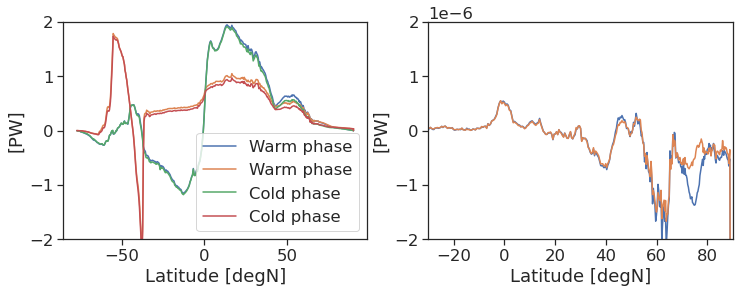

In [58]:
# Specific heat capacity 
cp = 4182e3 # J/m3
topw = 1e-15 # J/s to PW

fig1, ax1 = plt.subplots(1,2,figsize=(12,4))

for i,(vt,vt_eiv) in enumerate( zip(ds_vt_all, ds_vt_eiv_all) ):
    
    # Integrate vertically 
    vt_glo = topw * cp * (vt['zoimevt_glo'] * da_orca05_depv).sum('depthv').isel(x=0).mean('time')
    vt_atl = topw * cp * (vt['zoimevt_atl'] * da_orca05_depv).sum('depthv').isel(x=0).mean('time')
    
    # Convergence
    dy = 0.5 * (da_orca05_e2t[1:,0] + da_orca05_e2t[0:-1,0])
    dvt_glo = (vt_glo[1:] - vt_glo[0:-1]) / dy
    dvt_atl = (vt_atl[1:] - vt_atl[0:-1]) / dy
    
    # Lat
    vlat = vt['nav_lat'].isel(time=0, x=0)
    vlat2 = 0.5 * (vlat[1:] + vlat[0:-1])
    # plot
    ax1[0].plot(vlat, vt_glo, label=label_list[i])
    ax1[0].plot(vlat, vt_atl, label=label_list[i])
    
    ax1[1].plot(vlat2, dvt_atl.rolling(y=11,center=True).mean(), label=label_list[i])
    
ax1[0].legend()
ax1[1].set_xlim([-30,90])
ax1[0].set_ylim([-2,2])
ax1[1].set_ylim([-2e-6,2e-6])

for ax in ax1:
    
    ax.set_ylabel('[PW]')
    ax.set_xlabel('Latitude [degN]')